In [1]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

/home/ubuntu/Qwen-Image-Edit-Angles


In [2]:
import math
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import lpips
import torch
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as TF

from qwenimage.experiment import ExperimentConfig
from qwenimage.experiments.experiments_qwen import ExperimentRegistry

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipping import of cpp extensions due to incompatible torch version 2.9.1+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
TMA benchmarks will be running without grid constant TMA descriptor.
2025-11-14 21:34:06.551004: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the envi

In [3]:

from collections import defaultdict
import statistics
from pydantic import BaseModel


class ExperimentSet(BaseModel):
    original: str
    comparisons: list[str]

    @classmethod
    def create(cls, *names):
        if len(names)<2:
            raise ValueError(f"{len(names)=}")
        orig = names[0]
        comp = names[1:]
        return cls(original=orig, comparisons=comp)

class SetData:
    def __init__(self, name: str):
        self.name=name
        report_dir = ExperimentConfig().report_dir
        output_dir = report_dir / f"{name}_outputs"
        self.image_paths = sorted(list(output_dir.glob("*.jpg")))
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, ind):
        return Image.open(self.image_paths[ind])

# transforms
transforms = T.Compose([
    T.ToImage(),
    T.RGB(),
    T.ToDtype(torch.float32, scale=True), # [0,1]
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # [-1,1]
])

def compare_lpips(loss_fn, image1, image2, resize=False, device="cuda", to_item=True):
    if image1.size != image2.size:
        if resize:
            image2 = image2.resize(image1.size, Image.LANCZOS)
        else:
            raise ValueError(f"Got mismatch {image1.size=} {image2.size=}")

    im1_t = transforms(image1).unsqueeze(0).to(device=device)
    im2_t = transforms(image2).unsqueeze(0).to(device=device)
    
    with torch.no_grad():
        score = loss_fn(im1_t, im2_t)
    
    if to_item:
        return score.float().item()
    return score

def compare_sets(experiment_set:ExperimentSet, sort_by_mean=False, loss_fn=None):
    original_data = SetData(name=experiment_set.original)
    comparison_data = [SetData(name=comp) for comp in experiment_set.comparisons]

    if loss_fn is None:
        loss_fn = lpips.LPIPS(net='alex')  # or 'vgg' or 'squeeze'
        if torch.cuda.is_available():
            loss_fn = loss_fn.cuda()

    all_set_errors = defaultdict(list)
    for i in range(len(original_data)):
        for comp in comparison_data:
            lpips_error = compare_lpips(loss_fn, original_data[i], comp[i])
            all_set_errors[comp.name].append(lpips_error)
    
    error_stat_list = []
    for name, errors in all_set_errors.items():
        err_mean = statistics.mean(errors)
        err_std = statistics.stdev(errors)
        err_len = len(errors)
        error_stat_list.append({
            'name': f"{name}",
            'mean': err_mean,
            'std': err_std,
            'len': err_len
        })
        
    err_df = pd.DataFrame(error_stat_list)
    report_dir = ExperimentConfig().report_dir
    err_df.to_csv(report_dir / f"{experiment_set.original}_{'_'.join(experiment_set.comparisons)[:100]}.csv")
    
    if sort_by_mean:
        err_df = err_df.sort_values('mean', ascending=False)


    fig, ax = plt.subplots(figsize=(12, 6))
    x_pos = range(len(err_df))

    # bar_x = err_df["name"]
    bar_h = err_df["mean"]
    bar_std = err_df["std"]
    bars = ax.bar(
        x_pos, bar_h, yerr=bar_std, 
        capsize=12, alpha=0.7, edgecolor='black'
    )

    ax.set_xlabel('LPIPS error for experiment type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Error', fontsize=12, fontweight='bold')
    ax.set_title(f"LPIPS comparison", 
                    fontsize=14, fontweight='bold')
    

    ax.set_xticks(x_pos)
    ax.set_xticklabels(
        # [row['experiment'] for _, row in plot_data.iterrows()], 
        err_df["name"],
        rotation=15, ha='right', fontsize=12
    )

    ax.grid(axis='y', alpha=0.3)

    
    for i, (idx, row) in enumerate(err_df.iterrows()):        
        ax.text(i - 0.2, row['mean'] + 0.01, f"{row['mean']:.3f}", 
                ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()

    plot_path = report_dir / f"{experiment_set.original}_{'_'.join(experiment_set.comparisons)[:100]}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')

    plt.show()
    


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


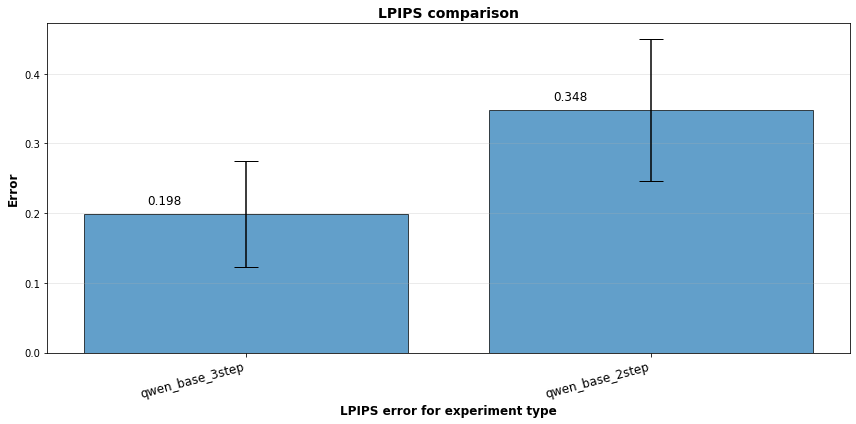

In [4]:
compare_sets(ExperimentSet.create(
    "qwen_base", "qwen_base_3step", "qwen_base_2step"
))


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


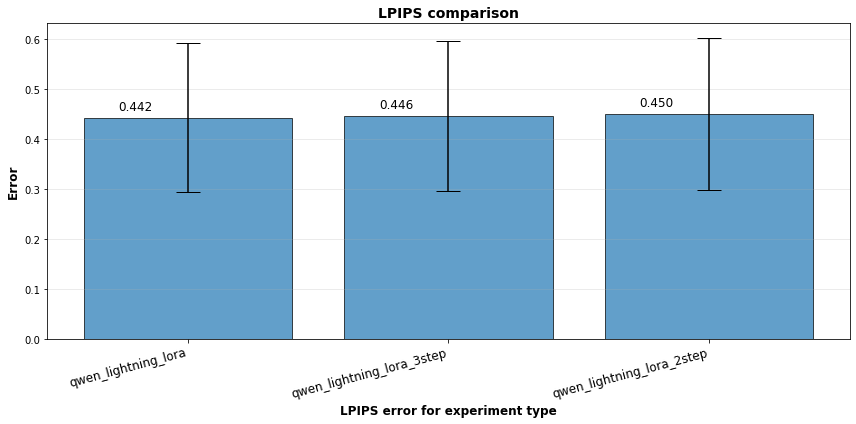

In [5]:
compare_sets(ExperimentSet.create(
    "qwen_base", "qwen_lightning_lora", "qwen_lightning_lora_3step", "qwen_lightning_lora_2step"
))

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


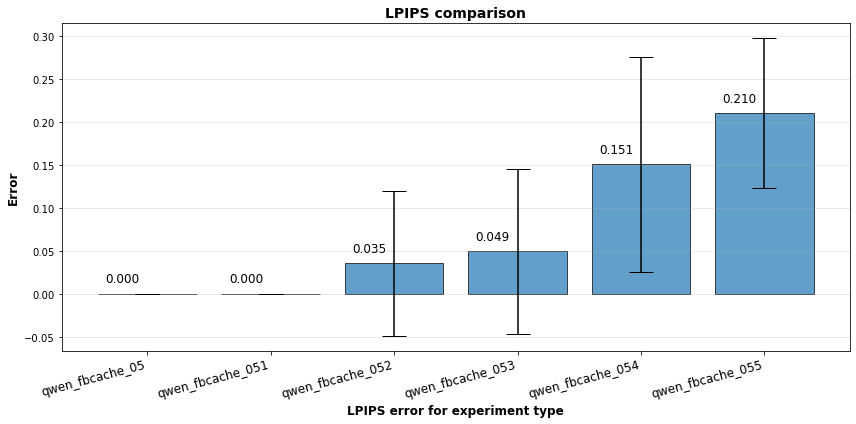

In [6]:
compare_sets(ExperimentSet.create(
    "qwen_base",
    "qwen_fbcache_05",
    "qwen_fbcache_051",
    "qwen_fbcache_052",
    "qwen_fbcache_053",
    "qwen_fbcache_054",
    "qwen_fbcache_055",
))


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


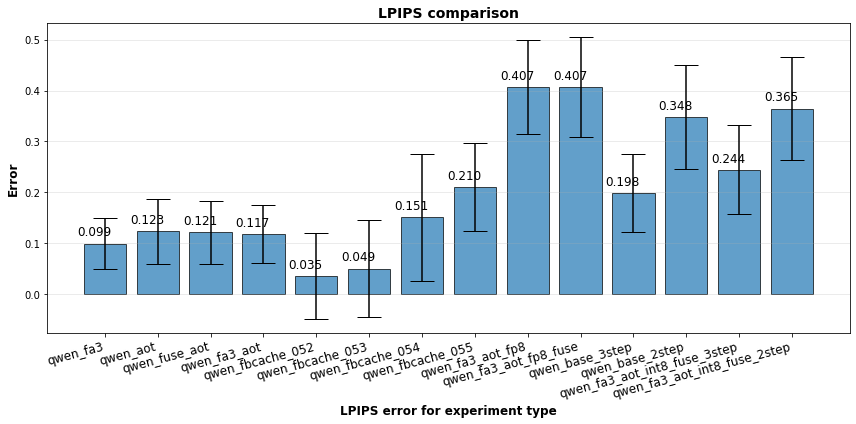

In [11]:
experiment_names = [
    "qwen_base",
    "qwen_fa3",
    "qwen_aot",
    "qwen_fuse_aot",
    "qwen_fa3_aot",

    "qwen_fbcache_052",
    "qwen_fbcache_053",
    "qwen_fbcache_054",
    "qwen_fbcache_055",

    "qwen_fa3_aot_fp8",
    "qwen_fa3_aot_fp8_fuse",

    "qwen_base_3step",
    "qwen_base_2step",
    "qwen_fa3_aot_int8_fuse_3step",
    "qwen_fa3_aot_int8_fuse_2step"


]

compare_sets(ExperimentSet.create(
    *experiment_names
))


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


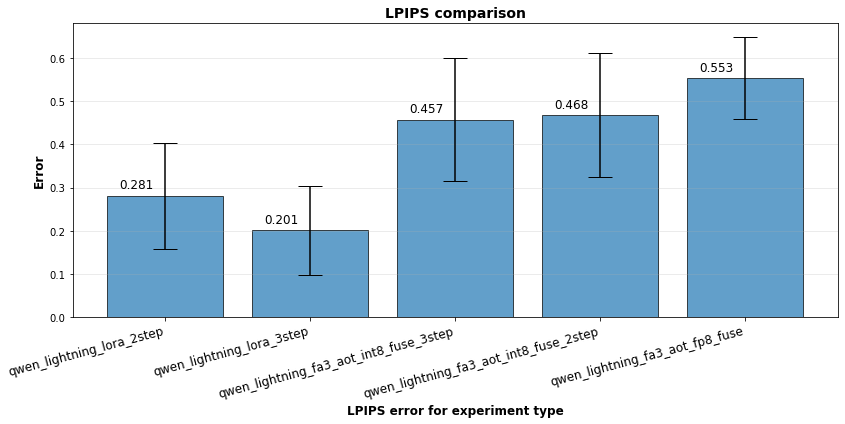

In [14]:
compare_sets(ExperimentSet.create(
    # "qwen_base",
    "qwen_lightning_lora",
    "qwen_lightning_lora_2step",
    "qwen_lightning_lora_3step",
    "qwen_lightning_lora_2step",
    "qwen_lightning_fa3_aot_int8_fuse_3step",
    "qwen_lightning_fa3_aot_int8_fuse_2step",
    "qwen_lightning_fa3_aot_fp8_fuse",
))